#**Team "MCE Friends": Miniproject 1 Colab Demo**

In this notebook, we step through the main exeution pipeline for the decision-tree based models used in classifying the wildfire test data for the Kaggle Competition.

## *PRELIMINARIES*:

To begin, let's import the main packages (we'll import the others as we go), and import the data:

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Preliminaries:
url_train = "https://github.com/lakigigar/Caltech-CS155-2021/blob/main/projects/project1/WILDFIRES_TRAIN.zip?raw=TRUE"
url_test = "https://github.com/lakigigar/Caltech-CS155-2021/blob/main/projects/project1/WILDFIRES_TEST.zip?raw=TRUE"
df_train = pd.read_csv(url_train, compression="zip", index_col="id")
df_test = pd.read_csv(url_test, compression = "zip", index_col="id")

Let's give the data a peek and grab some cursory information:

In [44]:
#Peek at data
print("TRAINING DATAFRAME:\n")
df_train.info()
print("\n\n TESTING DATAFRAME: \n\n")
df_test.info()
print("\n PEEK AT TRAINING DATA:")
df_train.head(5)


TRAINING DATAFRAME:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285382 entries, 0 to 285381
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   LATITUDE                    285382 non-null  float64
 1   LONGITUDE                   285382 non-null  float64
 2   STATE                       285382 non-null  object 
 3   DISCOVERY_TIME              143974 non-null  float64
 4   FIRE_SIZE                   285382 non-null  float64
 5   FIPS_NAME                   144822 non-null  object 
 6   FIPS_CODE                   144822 non-null  float64
 7   SOURCE_REPORTING_UNIT_NAME  285382 non-null  object 
 8   DATE                        285382 non-null  object 
 9   LABEL                       285382 non-null  int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 24.0+ MB


 TESTING DATAFRAME: 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 73035 entries, 285382 to 358416
Da

,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE,LABEL
id,,,,,,,,,,
0,38.205000,-120.335000,CA,130.0,0.10,NaN,NaN,Stanislaus National Forest,1992-01-01,1
1,33.813100,-85.104300,GA,1115.0,1.17,Haralson,143.0,Georgia Forestry Commission,1992-01-01,4
2,32.201000,-82.498700,GA,1600.0,0.07,Montgomery,209.0,Georgia Forestry Commission,1992-01-01,2
3,32.509300,-81.708600,GA,1215.0,4.40,Bulloch,31.0,Georgia Forestry Commission,1992-01-01,4
4,33.663889,-116.171944,CA,NaN,0.20,NaN,NaN,CDF - Riverside Unit,1992-01-01,2


This gives us a cursory glance at the data we'll be using, and we can also see that there are `NaN` values in only three particular columns, the `FIPS_NAME`, `FIPS_CODE`, and `DISCOVERY_TIME` columns. We will have to be careful about how we handle these if we want a high-performing model.

Furthermore, one can look at the data and see that the `FIPS_NAME` column is perfectly correlated to the `FIPS_CODE` column - that is, that the code column gives the id code of the name column. Therefore, we do not have to include the name column in this model, as its information is already categorically encoded in the code column (and, by keeping it out, we decrease the dimension size by one, which makes our model simpler, hooray!)


With our preliminaries out of the way, we can begin the ETL (**E**xtract, **T**ransform, **L**oad) process on our data before inputting into a model training pipeline.

#*DATA: FORMATTING*

The first thing we need to do is get the data we have into the formats we want for the model. Of the provided data types, we see there are 4 types of numerical data (`LATITUDE`, `LONGITUDE`, `DISCOVERY_TIME`, `FIRE_SIZE`), one date column that has been read-in as a string, and the rest are categorical data. Pandas already converted all the numerical columns into numbers for us (the `DISCOVERY_TIME` column is technically a 24-hour time-formatted data column, for for our purposes reading the number as a float from 0-2400 is also indicative of the relationship between the temporal label and the time of day, so this plays in our favor), and so it is left up to us to treat the date and categorical data as we see fit and get the informaiton into numerical form before we can move on.

In [45]:
#Let's build a dataframe of the input data we already have in usable form
input_data = df_train[['LATITUDE', 'LONGITUDE', "FIRE_SIZE", "LABEL"]].copy()
test_data = df_test[['LATITUDE', 'LONGITUDE', 'FIRE_SIZE']].copy()

Numerical ML models cannot take categorical data, input features must be in a *numerical* format. Therefore, we must choose how to "encode" our categorical and date data. Due to the number of DISTINCT features in the FIPS columns (too many for one-hot encoding, which would increase our dimensions by nearly 200), we choose to *label-encode* these categories (each distinct category gets its own integer), which pandas has readily-built functions to accomplish. This gives us the added benefit of turning `NaN`s into their *own* category, in case the choice by the original scribe to leave out a label is also indicative of a trend in the data. This also means we do not have to excise these values from the data set, and therefore have more training data to work with.


We must also keep in mind: *whatever we do to the training data, we must also do to the testing data*, if we want our model inputs (and results) to be accurate. Therefore, we must also encode the categories of the training set according to the categories of the training set (this results in a few more `NaN`s since there are more distinct categories in the test data than the training data, but we have handled those by giving them their own category).

In [46]:
#Since FIPS_NAME and FIPS_CODE are perfectly correlated (the code gives the id number of name),
#there is only need to use one of these two columns. Let's use FIP_CODE.
#SOURCE_REPORTING_UNIT_NAME, FIPS_CODE Columns:
fipscategories = df_train["FIPS_CODE"].astype('category').cat.categories
namecategories = df_train["SOURCE_REPORTING_UNIT_NAME"].astype('category').cat.categories

fipcdlbl = df_train["FIPS_CODE"].astype('category').cat.codes
srcnamelbl = df_train["SOURCE_REPORTING_UNIT_NAME"].astype('category').cat.codes
input_data["FIPCOD_CAT"] = fipcdlbl
input_data["SRCNAM_CAT"] = srcnamelbl

srcnamelbl_test = pd.Series(pd.Categorical(df_test['SOURCE_REPORTING_UNIT_NAME'].to_list(),
               categories=namecategories)).cat.codes.values
fipcdlbl_test = pd.Series(pd.Categorical(df_test['FIPS_CODE'].to_list(),
               categories=fipscategories)).cat.codes.values
test_data["FIPCOD_CAT" ] = fipcdlbl_test
test_data["SRCNAM_CAT"] = srcnamelbl_test

For the time data, we can make use of the `datetime` library to convert the string into desirable numeric data. As a group, we believe the most relevant information about the fires for the model will be encoded into what fraction of the year they occur, that is, their day-of-the-year (1-365, or 366 for leap years). This permits the data to reflect seasonal trends, and account for year-over-year variability in fires (for instance, if we know the summer months are particularly problematic, then the summer range of days-of-the-year will capture this information in the aggregate, rather than trying to split it over month and year and see large variability in some months/years vs others).

In [47]:
#Date column:
#For dates, the most information will likely come from the day of the year, which
#should capture monthly and seasonal data in a continuous spread.
from datetime import datetime
day_of_year=df_train['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timetuple().tm_yday)
input_data["DAY_OF_YR"] = day_of_year

day_test = df_test['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timetuple().tm_yday)
test_data['DAY_OF_YR'] = day_test

With this step complete, we have already handled most of the `NaN`s in the data, but a few remain in the time column, which we still want to use. Therefore, we can now move onto the next step of the process, which is:

#*DATA: CLEANING/ENGINEERING*

All of our data is now formatted properly, and we now wish to take this data and make it into the numerical features we wish to actually input to the model (we already technically began this process when we converted our date strings into a new feature, the day-of-the-year). The only remaining `NaN`s in the data are found in the `DISCOVERY_TIME` column, which is a numerical form we would like to include as a feature to our model.

In data science and ML, there are many ways to handle `NaN`s when they cannot be categorized (or the user does not want them to be), among the main choices being imputation (replacing `NaN`s with the mean/median/mode of their respective feature, or making some attempt to predict them from other feature correlations), excising (removing the entries with `NaN`s, which can significantly reduce the amount of available data or obscure subtle trends which may be related to the `NaN`s), or categorizing (like what happened with the above section, we make the `Nan`s clearly distinct from the rest of the entries in their column).

Likewise, a model will stand a better chance of performance if the trends it has to pick up are relatively localized in the parameter space, and exist in a "beneficial" way (for instance, gradient descent has an easier time navigating the parameter space when the contours of the objective function are circular, rather than ovular, and classifiers can better distinguish boundaries when they are more localized in space, rather than spread very far over the dimensions of other features). Therefore, it is usually helpful to *standardize* (give the z-score of the data, i.e. scale it to have a mean of 0 and a standard deviation of 1) or *0-1 scale* (make the minimum zero and the maximum 1) the numerical data of the features, or at least make sure the majority of each feature lies in a similar-order range. Therefore, we will also scale/standardize our numerical features to lie in a similar range (however, we will not do this to the categorical data, as "squishing" the trends in categories closer together is precisely what we do *not* want our model to deal with, and these shall remain untouched to permit wider distances between categories in the feature space).

Let's start with the time column. We can 0-1 scale the time data, and then also give the `NaN`s a -1, which categorizes the `NaN`s and permits us to keep *all* the data in the training set (and correspondingly shift the test-times, too)

In [48]:
#The only remaining NaNs in the dataset are in the discovery time column
#Let's 0-1 scale this column and give the NaNs a -1:
times = df_train["DISCOVERY_TIME"].to_numpy()
goodtimes = times[~np.isnan(times)]
gtmin = np.amin(goodtimes)
gtmax = np.amax(goodtimes-gtmin)
goodtimes = (goodtimes-gtmin)/gtmax
times[~np.isnan(times)]=goodtimes
times[np.isnan(times)]=-1
input_data["SCALED_TIME"]=times

time_test = df_test['DISCOVERY_TIME'].to_numpy()
time_test = (time_test - gtmin)/gtmax
time_test[np.isnan(time_test)]=-1
test_data["SCALED_TIME"] = time_test

We can then also scale the rest of the features we've input so far:

In [49]:
#Latitude (Standardized):
latmean = input_data['LATITUDE'].mean()
latstd = input_data['LATITUDE'].std()
input_data['LATITUDE']=(input_data['LATITUDE']-latmean)/latstd
test_data['LATITUDE'] = (test_data['LATITUDE']-latmean)/latstd

#Longitude (Standardized):
lonmean = input_data['LONGITUDE'].mean()
lonstd = input_data['LONGITUDE'].std()
input_data['LONGITUDE']=(input_data['LONGITUDE']-lonmean)/lonstd
test_data['LONGITUDE'] = (test_data['LONGITUDE']-lonmean)/lonstd

#Day-Of-Year (0-1 scaled):
daymax = input_data['DAY_OF_YR'].max()
input_data['DAY_OF_YR']=input_data['DAY_OF_YR']/daymax
test_data['DAY_OF_YR']=test_data['DAY_OF_YR']/daymax

Our preliminary data investigation also showed all of the data as being categorized as from California or Georgia. We believe we can extract more utility from this to use alongside the lat/lon data, and so choose to use k-means clustering to provide geographical *clusters*, instead of just states, to use in our model input (perhaps crime-related fires are more localized in a particular county or region, or natural fires more prevalent in the Central Valley, etc., there may be locally-dependent trends as well). These clusters will give us another categorical (label-encoded) feature to use in our data. We can also visualize these clusters afterwards and show their centroids:

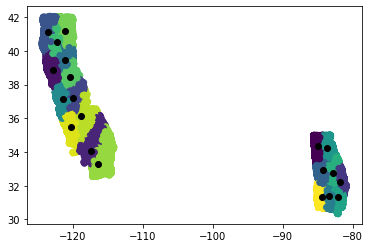

In [50]:
#Now let's make cluster labels instead of just lat/lon, and visualize them:
from sklearn.cluster import KMeans
clusters = KMeans(20).fit(df_train[['LATITUDE', 'LONGITUDE']])
plt.scatter(df_train['LONGITUDE'], df_train['LATITUDE'], c = clusters.labels_)
plt.scatter(clusters.cluster_centers_[:,1], clusters.cluster_centers_[:,0], c = "black")
plt.show()
input_data['CLUSTER_ID'] = clusters.labels_

test_clusters = clusters.predict(df_test[['LATITUDE', 'LONGITUDE']])
test_data['CLUSTER_ID'] = test_clusters

With all these manipulations completed, let's take another peek at our new input data:

In [51]:
input_data

,LATITUDE,LONGITUDE,FIRE_SIZE,LABEL,FIPCOD_CAT,SRCNAM_CAT,DAY_OF_YR,SCALED_TIME,CLUSTER_ID
id,,,,,,,,,
0,0.988290,-0.985736,0.10,1,-1,157,0.002732,0.055108,14
1,-0.401536,0.925103,1.17,4,72,71,0.002732,0.472658,0
2,-0.911689,1.066425,0.07,2,104,71,0.002732,0.678253,12
3,-0.814127,1.109278,4.40,4,16,71,0.002732,0.515049,3
4,-0.448754,-0.759941,0.20,2,-1,14,0.002732,-1.000000,16
...,...,...,...,...,...,...,...,...,...
285377,-0.861656,1.044990,0.25,4,88,55,0.994536,-1.000000,12
285378,1.033018,-1.013965,0.10,2,-1,0,0.994536,0.437050,14
285379,-0.728275,1.053206,0.01,2,84,53,0.994536,-1.000000,12


Another point to consider is that some of our variables may be *correlated*. There is nothing inherently evil about correlation between predictive features, but there are two downsides. Unless they are explicitly desired by the user, correlation between features can sometimes imapct model performance (correlations mean the model has a harder time telling the "true" contribution of each feature *separately* to the result, since the changes in one feature that affect the result are also matched by correlated changes in other features). Furthermore, the more correlated features are, the less data one of the features relatively provides to the model (its impact on the result is already captured by other features), and therefore it may be more advantageous to sacrifice a small amount of relative informaiton in favor of a decreased dimension size. Therefore, unless explicitly desired, we can also take a look at the correlation between features and choose (or not choose) to drop any highly-correlated (absolute value greater than 2/3) features, by visualizing a Pearson correlation matrix between all our now-numerical features:

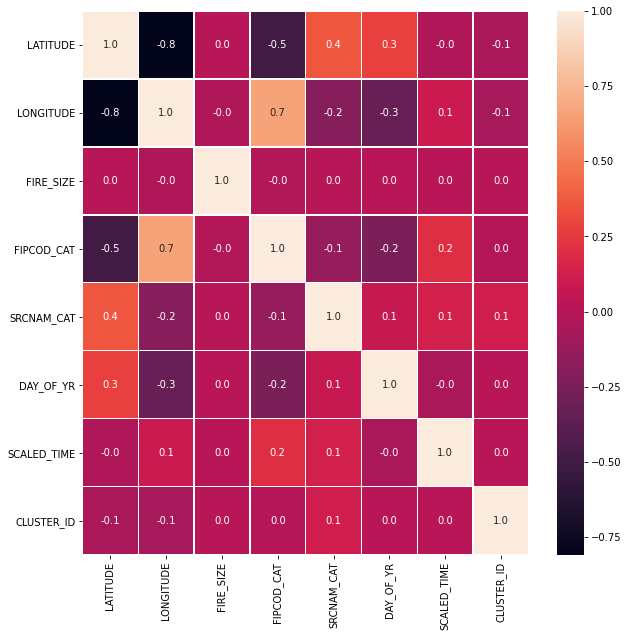

In [52]:
#Correlation matrix:
import seaborn as sns
cors = input_data.drop(columns = "LABEL").corr()
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cors, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

The results show us that Latitude and longitude are relatively highly correlated (but that's okay, we want these features anyway, and want to investigate whether there are more subtle trends between smaller values of the latitude and longitude, beyond the macroscopic correlation. This is also to be expected, because the data are either from California or Georgia, which will create artificial correlation between the data we have to work with, since George is more south-west than California), but we also see that `FIPCOD_CAT` (our categorized FIP codes) is highly correlated to longiditude and latitude. In this case, since we care more about longitude, we choose to drop `FIPCOD_CAT` from the model in favor of downsizing the input dimensions. This leaves behind no highly-correlated variables that we do not explicitly desire.

In [53]:
input_data = input_data.drop(columns = 'FIPCOD_CAT')
test_data = test_data.drop(columns = 'FIPCOD_CAT')

With our ETL complete, it is now time for:

#*SET-UP FOR MODEL TRAINING*

We do not want to overfit our data, and we do not want to just assume with no evidence that our training will go well, so we choose to use standard five-fold cross-validation for training and evaluating our model. We can thus use `sklearn`'s `KFold` module to accomplish this task:

In [54]:
from sklearn.model_selection import KFold

#Use standard 5-fold cross-validation
nsplits = 5
kf = KFold(n_splits = nsplits, shuffle = True)

output = input_data['LABEL']
input = input_data.drop(columns = 'LABEL')

#*TRAIN/EVALUATE A CHOSEN MODEL TYPE*

The data and setup are now primed for model training, which we can encode into a loop for running and evaluating over each of the folds.

Our group chose to work with Decision-Tree based ensemble methods, which involved Random Forests and Extreme Gradient Boosted trees, as we figured they would perform well given our choice to use categorical data in addition to our numerical data in the input. To evaluate the model performance, we choose to use the same AUC score from the competition, in the hopes that increasing the AUC score on the validation sets will also indicate a high AUC on the testing data. We also tried to use simpler (low-tree) models, to prevent overfitting of the testing data, and sample the training data instead of using the entire data set at once (both again to avoid overfitting, and also to speed up the training process).

After a few iterations of tests, our group also chose to a run a (much lengthier) hyper-parameter optimization for these models in order to inform model choice, which would be a prohibitively long code to insert here. Instead, we present the training of our two submitted models with optimal hyperparameters below, that will be our submitted models for the competition, and will leave hyperparameter discussion to the report.

In [55]:
from sklearn.metrics import roc_auc_score as evalmetric
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

params_xg = {
  'colsample_bynode': 0.8,
  'learning_rate': 1,
  'max_depth': int(5),
  'num_parallel_tree': 50,
  'subsample': 0.5825,
}



'''MAKE SURE THE TOP GRADIENT-BOOSTING MODEL CODE IS PUT HERE TOO, AND SET THE
PARAMS TO THE VALUES WE USE ON OUR SUBMISSIONS'''

results_tree = np.zeros(nsplits)
results_xg   = np.zeros(nsplits)
idx = 0

for train_index, test_index in kf.split(input_data):
     print("ON SET: ", idx+1)
     X_train, X_test = input.iloc[train_index], input.iloc[test_index]
     y_train, y_test = output.iloc[train_index], output.iloc[test_index]
     
     #METHOD 1: Random Forest Class_treeifier
     clf_tree = RandomForestClassifier(n_estimators=50, max_depth = 10,
                                  criterion='gini', max_samples =50000)
     clf_tree.fit(X_train, y_train)

     #METHOD 2: Extreme Gradient Boosted Trees
     clf_xg = XGBClassifier(n_estimators = 50, subsample = 0.5825, max_depth = 5 ,
                            learning_rate = 1, colsample_bynode = 0.8)
     clf_xg.fit(X_train, y_train)

     #Calculate the evaluation metric for both models
     #Forest Metric     
     testlabels = y_test.to_numpy()
     metric_tree = evalmetric(testlabels, clf_tree.predict_proba(X_test), multi_class = "ovr")
     results_tree[idx] = metric_tree 
     print("Forest Score: ", metric_tree)

     #XG
     metric_xg = evalmetric(testlabels, clf_xg.predict_proba(X_test), multi_class = "ovr")
     
     results_xg[idx] = metric_xg
     print("Xgboost Score: ", metric_xg)

     idx = idx + 1



ON SET:  1
Forest Score:  0.8012290844448631
Xgboost Score:  0.8129553214331653
ON SET:  2
Forest Score:  0.8019005395533099
Xgboost Score:  0.8114524072462119
ON SET:  3
Forest Score:  0.8017070872154463
Xgboost Score:  0.81311819324979
ON SET:  4
Forest Score:  0.8006025019545846
Xgboost Score:  0.8112702931005076
ON SET:  5
Forest Score:  0.8005236578133725
Xgboost Score:  0.811901428084822


With the training of the models complete, we can look to:

#*SUMMARY OF TRAINING*

The below box will show the average evaluation metric from the models on the data, and also display relative feature importance:

[0.80122908 0.80190054 0.80170709 0.8006025  0.80052366]
Average success across kfolds (tree):  0.8011925741963152
Average success across kfolds (XGboost):  0.8121395286228992
On entire training data set (tree):  0.8104674139975621
On entire training dataset (XGboost):  0.8304844048018823


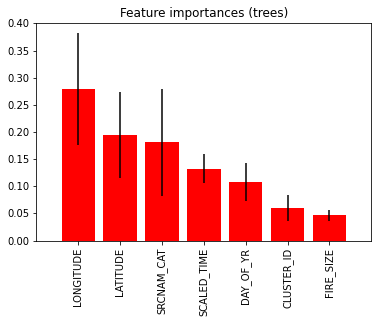

In [56]:
#Summarize training statistics
print(results_tree)
print("Average success across kfolds (tree): ", np.average(results_tree))
print("Average success across kfolds (XGboost): ", np.average(results_xg))
print("On entire training data set (tree): ", evalmetric(input_data['LABEL'].values,
                                                        clf_tree.predict_proba(input), multi_class = "ovr"))
print("On entire training dataset (XGboost): ", evalmetric(input_data['LABEL'].values, 
                                                 clf_xg.predict_proba(input), multi_class = "ovr"))


#Plot tree feature importance
importances_tree = clf_tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_tree.estimators_],
             axis=0)
indices = np.argsort(importances_tree)[::-1]
plt.figure()
plt.title("Feature importances (trees)")
plt.bar(input.columns[indices], importances_tree[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(input.columns[indices], rotation = "vertical")
plt.xlim([-1, input.shape[1]])
plt.show()

We see these values are both high enough to suggest a successful model, but not so high as to suggest overfitting, and so we are satisfied with our choices. We also see that the lon/lat data were the most relevant features for the forest, while the fire-size data was the least helpful. With the model setup complete, it remains to generate its predicted labels on the test data and export them as a .csv:

#*GENERATE TESTING FILE*



In [57]:
#Generate the output file:
probs_tree = clf_tree.predict_proba(test_data)
probs_xg = clf_xg.predict_proba(test_data)

#WRITE TO CSV
datoutput_tree = pd.DataFrame(probs_tree, columns = ["P1", "P2", "P3", "P4"])
datoutput_tree['id'] = test_data.index
datoutput_tree = datoutput_tree.set_index('id')
datoutput_tree.to_csv("test_prdictions_tree.csv")

datoutput_xg = pd.DataFrame(probs_xg, columns = ["P1", "P2", "P3", "P4"])
datoutput_xg['id'] = test_data.index
datoutput_xg = datoutput_xg.set_index('id')
datoutput_xg.to_csv("test_predictions_xg.csv")